In [2]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls
import cvxpy as cp
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time


In [80]:

np.random.seed(0)

#Function the generate the measurements based on random pooling using the binomial distribution
def construct_measurements_randompool(x, M, A):
    """
    Constructs measurements based on the given parameters.

    Parameters:
    x (array-like): The input data.
    M (int): The number of measurements to construct.
    A Random matrix

    Returns:
    array-like: The constructed measurements.

    """
    # Construct the measurements
    X = np.tile(x, (M, 1))
    Y = np.logical_or.reduce(A * X, axis=1).astype(int)
    return Y


def nnomp(y, A, tolerance=1e-10, threshold=0.26):
    """
    Perform Non-negative Orthogonal Matching Pursuit (NNOMP) algorithm.

    Parameters:
    - y: numpy array, the measurement vector
    - A: numpy array, the sensing matrix
    - tolerance: float, the tolerance level for convergence (default: 1e-10)
    - threshold: float, the threshold value for thresholding (default: 0.05)

    Returns:
    - x_hat: numpy array, the estimated sparse signal
    """
    r = y.copy()
    S = set()
    n = A.shape[1]
    x_hat = np.zeros(n)

    count = 0
    while np.linalg.norm(r) > tolerance and len(S) < A.shape[0]:
        # Compute correlation with residual
        h = np.dot(A.T, r)

        # Find index of maximum correlation
        i = np.argmax(h)

        # Avoid adding the same index to S
        if i in S:
            break

        S.add(i)  # Add this index to the support set

        # Solve non-negative least squares problem for current support set
        As = A[:, list(S)]
        z, _ = nnls(As, y)

        # Update x_hat with the current non-negative solution
        x_hat[list(S)] = z

        # Update residual
        r = y - np.dot(A, x_hat)
        count += 1

    # Values may not be 0 or 1 as required by the algorithm, therefore thresholding is carried out
    x_hat = np.where(x_hat < threshold, 0, x_hat)  # This replaces values below threshold with 0
    x_hat = np.where(x_hat >= threshold, 1, x_hat)  # This sets values above or equal to threshold to 1
    x_hat=x_hat.astype(bool)
    return x_hat

def basis_pursuit(y, A, c=0.1, threshold=0.26):
    """
    Solve the basis pursuit problem to recover a sparse signal.

    Parameters:
    - y: The observed signal.
    - A: The measurement matrix.
    - c: The maximum error tolerance.
    - threshold: The threshold value for applying sparsity.

    Returns:
    - x_hat: The recovered sparse signal.

    """

    # n is the number of variables in the signal x we want to recover
    n = A.shape[1]

    # Define the optimization variable
    x = cp.Variable(n)

    # Define the objective function (minimize the l1 norm of x)
    objective = cp.Minimize(cp.norm(x, 1))

    # Define the constraints (Ax = y)
    constraints = [cp.norm(A @ x - y, 2) <= c, x >= 0, x <= 1]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve(solver=cp.SCS, verbose=False)

    if x.value is not None:  # Check if the solution exists
        x_hat = x.value
        # Apply threshold if necessary
        x_hat = np.where(x_hat < threshold, 0, x_hat)  # This replaces values below threshold with 0
        x_hat = np.where(x_hat >= threshold, 1, x_hat)  # This sets values above or equal to threshold to 1

    else:
        # print("Solution not found or problem is infeasible.")
        x_hat = np.zeros(n)
    x_hat=x_hat.astype(bool)
    return x_hat

def comp(y, A):
    """
    Check for defective items based on Boolean compressed sensing.

    Parameters:
    y (ndarray): Binary vector representing the test results.
    A (ndarray): Boolean matrix representing the test matrix.

    Returns:
    ndarray: Boolean vector indicating the defective items.
    """
    # All items which do not occur in any negative tests are possibly defective, pd
    return np.sum(A[np.invert(y.astype(bool)),:],0)==0

def dd(y, A):
    """
    Compute the defective items using Boolean compressed sensing.

    Parameters:
    - y: 1D numpy array representing the measurements.
    - A: 2D numpy array representing the sensing matrix.

    Returns:
    - dd: 1D numpy array indicating the defective items.

    Algorithm:
    1. Compute the positive detections using the comp function.
    2. Initialize dd as a boolean array of the same shape as pd, filled with False.
    3. For each measurement in A corresponding to a positive detection:
       - If there is only one positive detection in the measurement, mark it as defective.
       - Update dd by performing element-wise logical OR between dd and the bitwise AND of the measurement and pd.
    4. Return dd.

    """
    pd = comp(y, A)
    dd = np.full_like(pd, False)
    for meas in A[y.astype(bool),:]:
        if np.sum(meas[pd])==1:
            dd |= meas.astype(bool)&pd
    return dd

def scomp(y, A):
    """
    Perform sparse compressed sensing using Boolean compressed sensing.

    Args:
        y (ndarray): The measurement vector.
        A (ndarray): The measurement matrix.

    Returns:
        ndarray: The estimated sparse signal.

    """
    ndnd = comp(y, A)
    x_hat = dd(y, A)
    unexplained = A[y == 1, :][[not np.any(meas.astype(bool) & x_hat) for meas in A[y == 1, :]], :]
    while unexplained.any():
        x_hat[np.argmax(np.sum(unexplained, 0) * ndnd)] = True
        unexplained = A[y == 1, :][[not np.any(meas.astype(bool) & x_hat) for meas in A[y == 1, :]], :]
    return x_hat

def hamming_distance(array1, array2):
    """
    Calculates the Hamming distance between two numpy arrays.

    Parameters:
    - array1 (numpy.ndarray): The first array.
    - array2 (numpy.ndarray): The second array.

    Returns:
    - int: The Hamming distance between the two arrays.

    """
    if array1.shape != array2.shape:
        raise ValueError("Arrays must have the same shape.")

    distance = np.count_nonzero(array1 != array2)
    return distance

def plot_hamming_heatmap(distance_matrix, method_name):
    """
    Plot a heatmap of the given distance matrix.

    Parameters:
    - distance_matrix (numpy.ndarray): The distance matrix to be plotted.
    - method_name (str): The name of the method used to generate the distance matrix.

    Returns:
    - None

    """
    # Plot the heat map
    # distance_matrix = distance_matrix[::-1]
    sns.heatmap(distance_matrix[::-1],annot=True, xticklabels=M_values, yticklabels=p_values[::-1], cmap='Greens')
    plt.xlabel('M (Number of Measurements)')
    plt.ylabel('p (Probability)')
    plt.title(f'Total Hamming Distance for {method_name}')
    plt.savefig(f'{method_name}_hamming_heatmap.png')
    plt.show()

def plot_hamming_heatmap_grid(algorithm, hamming_dict, M_values, p_values):
    """
    Plot a heatmap of the given distance matrix.

    Parameters:
    - algorithm (list): List of algorithm names.
    - hamming_dict (dict): Dictionary containing the distance matrices.
    - M_values (list): List of M values.
    - p_values (list): List of p values.
    

    Returns:
    - None

    """
    
    fig, ax = plt.subplots(len(hamming_dict), 1, figsize=(7, 3*len(hamming_dict)))    
    for i, key in enumerate(algorithm):
        sns.heatmap(hamming_dict[key][::-1], annot=True, xticklabels=M_values, yticklabels=p_values[::-1], cmap='Greens', ax=ax[i])
        ax[i].set_xlabel('M (Number of Measurements)')
        ax[i].set_ylabel('p (Probability)')
        ax[i].set_title(f'Average Hamming Distance for {key}')
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)
 
        
    plt.rcParams['font.size'] = '12'
    plt.tight_layout()
    
    plt.savefig('hamming_time_heatmap.pdf')
        
    plt.show()

def plot_time_heatmap(distance_matrix, method_name):
    # Plot the heat map
    sns.heatmap(distance_matrix[::-1], xticklabels=M_values, yticklabels=p_values[::-1], cmap='Reds')
    plt.xlabel('M (Number of Measurements)')
    plt.ylabel('p (Probability)')
    plt.title(f'Total Process Time for {method_name}')
    plt.savefig(f'{method_name}_time_heatmap.png')
    
    plt.show()

def plot_confusion_matrices(confusion_matrix_dict,p_dict):
    """
    Plot the confusion matrices for the given dictionary of confusion matrices.

    Parameters:
    - confusion_matrix_dict (dict): A dictionary containing the confusion matrices.

    Returns:
    - None

    """
    fig, axes = plt.subplots(len(confusion_matrix_dict), 1, figsize=(9, 2*len(confusion_matrix_dict)))
    for i, (key, matrix) in enumerate(confusion_matrix_dict.items()):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[i])
        axes[i].set_title(f'{key}, p={p_dict[key]}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    plt.rcParams['font.size'] = '17'
    plt.tight_layout()
    plt.savefig('confusion.pdf')
    plt.show()
    


In [31]:

# Parameters
N = 100  # Size of each measurement
groups = 1000  # Number of groups
#Load the data (the N*1 sparse vector)
# ith value of 0: not infected and 1: infected
#group_data M samples of size 100 patients
group_data=loadmat('GroupTesting.mat')['x'][0:groups,:N]

# Define the range of values for p and M
# p_values =np.array([0.001,0.0025,0.005,0.0075,0.01,0.03,0.05,0.1,0.4])

p_values =np.array([0.005,0.01,0.03,0.05,0.1,0.2])
M_values = np.array([30,50,70,90,110])

algorithms = {
        "basis pursuit":basis_pursuit,
        "Orthogonal Matching Pursuit":nnomp,
        "COMP":comp,
        "DD":dd,
        "SCOMP":scomp}

# Initialize an empty dictionary to store the hamming distances
hamming_distance_mat_dict = {key:np.zeros((len(p_values),len(M_values))) for key in algorithms}
tot_perf_time_mat_dict = {key:np.zeros((len(p_values),len(M_values))) for key in algorithms}
matrix_meas_dict={}

# Iterate over p and M values
for ind_p,p in enumerate(p_values):
    for ind_M,M in enumerate(M_values):
        print("p: ",p,"\t M:", M)
        # Initialize the total hamming distance for each algorithm
        tot_hamming_distance_dict = {key:0 for key in algorithms}
        tot_perf_time_dict = {key:0 for key in algorithms}

        A = np.random.binomial(1, p, size=(M, N))
        matrix_meas_dict[p,M]=A
        # Iterate over group_data
        for i, s in enumerate(group_data):
            Y= construct_measurements_randompool(s, M, A)
            # Iterate over algorithms
            for key, algo in algorithms.items():
                # Apply the algorithm to obtain the estimated signal and track process time
                st = time.process_time()
                z = algo(Y, A)
                et = time.process_time()

                # Calculate the hamming distance between the true signal and the estimated signal
                hamming_dist = hamming_distance(s, z)

                # Update the total hamming distance for the current algorithm
                tot_hamming_distance_dict[key] += hamming_dist
    
                # Update the total performance time for the current algorithm
                tot_perf_time_dict[key] += (et-st)


        # Store the total hamming distance for this p and M combination
        for key in algorithms:
            hamming_distance_mat_dict[key][ind_p,ind_M] = tot_hamming_distance_dict[key]/groups
            tot_perf_time_mat_dict[key][ind_p,ind_M] = tot_perf_time_dict[key]/groups


p:  0.005 	 M: 30
p:  0.005 	 M: 50
p:  0.005 	 M: 70
p:  0.005 	 M: 90
p:  0.005 	 M: 110
p:  0.01 	 M: 30
p:  0.01 	 M: 50
p:  0.01 	 M: 70
p:  0.01 	 M: 90
p:  0.01 	 M: 110
p:  0.03 	 M: 30
p:  0.03 	 M: 50
p:  0.03 	 M: 70
p:  0.03 	 M: 90
p:  0.03 	 M: 110
p:  0.05 	 M: 30
p:  0.05 	 M: 50
p:  0.05 	 M: 70
p:  0.05 	 M: 90
p:  0.05 	 M: 110
p:  0.1 	 M: 30


/home/frank/miniconda3/envs/bool_12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


p:  0.1 	 M: 50
p:  0.1 	 M: 70
p:  0.1 	 M: 90
p:  0.1 	 M: 110
p:  0.2 	 M: 30
p:  0.2 	 M: 50
p:  0.2 	 M: 70
p:  0.2 	 M: 90
p:  0.2 	 M: 110


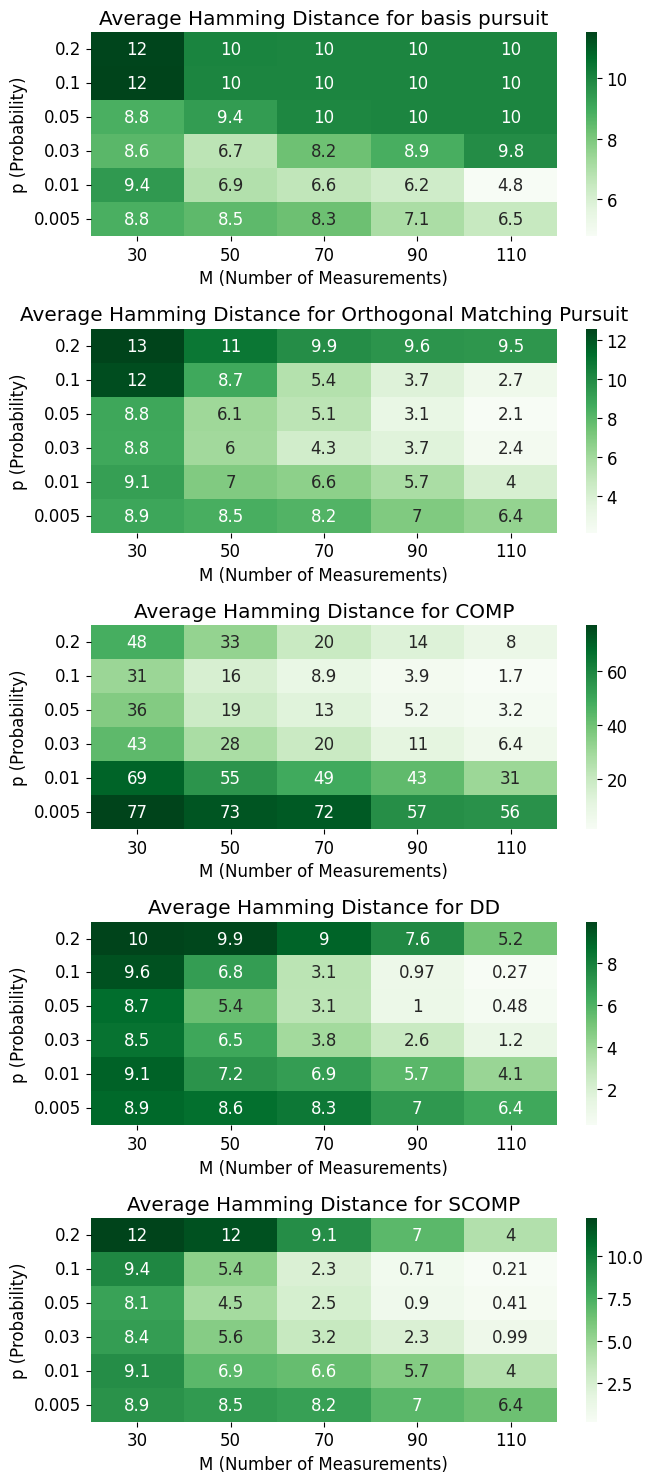

In [68]:

plot_hamming_heatmap_grid(algorithms,hamming_distance_mat_dict,M_values,p_values )
plot_hamming_heatmap_grid(algorithms,hamming_distance_mat_dict)
for key in algorithms:
    # plot_hamming_heatmap(hamming_distance_mat_dict[key], key)
    plot_time_heatmap(tot_perf_time_mat_dict[key], key)



basis pursuit:9.086972185987179
Orthogonal Matching Pursuit:1.0163995640004941
COMP:0.015897109002253274
DD:0.11545309599205211
SCOMP:0.87543885796822


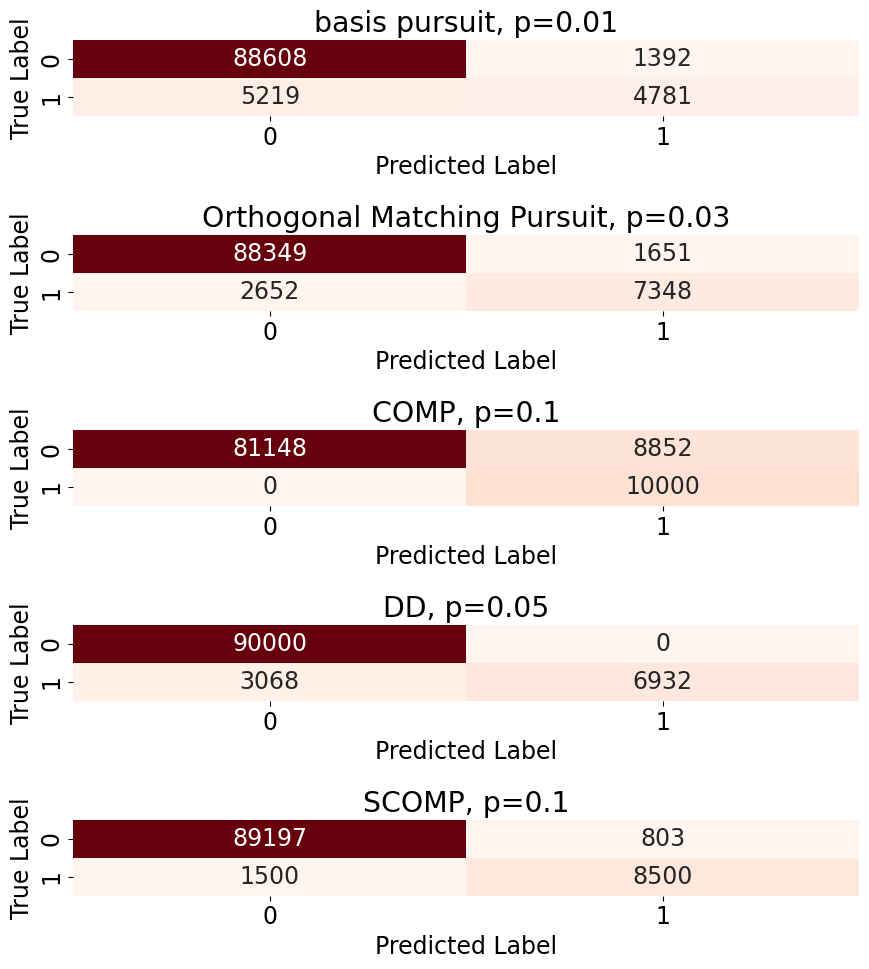

In [82]:

#now lets calculate the confusion matrices for more optimal parameters
M=70
p_dict = {"basis pursuit":0.01,
        "Orthogonal Matching Pursuit":0.03,
        "COMP":0.1,
        "DD":0.05,
        "SCOMP":0.1}

tot_confusion_dict = {key:0 for key in algorithms}

perf_time_dict={}

for key, algo in algorithms.items():
    # Iterate over group_data
    perf_time_dict[key] = 0
    for i, s in enumerate(group_data):
        A=matrix_meas_dict[p_dict[key],M]
        Y= construct_measurements_randompool(s, M,A )
        # Apply the algorithm to obtain the estimated signal
        st = time.process_time()
        z = algo(Y, A)
        et = time.process_time()
        # Update the total performance time for the current algorithm
        perf_time_dict[key] += (et-st)
        # Calculate the confusion matrix
        tot_confusion_dict[key] += confusion_matrix(s, z)
    print(key+":"+str(perf_time_dict[key]))

plot_confusion_matrices(tot_confusion_dict,p_dict)